# 遥感图像场景分类

**目标：**


1.   使用深度神经网络(Deep Neural network, DNN)来解决图像分类问题
2.   学习基本的DNN训练方法
3.   熟悉目前主流的深度学习框架Pytorch

本次作业我们提供了训练集、验证集（均带有标签）以及测试集（不带标签），你可以通过训练集和验证集寻找最好的模型，并在测试集上得到你的预测结果。

最后你需要将预测结果提交到kaggle上(https://www.kaggle.com/competitions/ml-dl-2023-hw2), 系统会自动返回精度

总的来说，本次作业的目标就是基于我们给定的代码，发挥你在课堂上学习到的知识，修改代码，从而得到尽可能高的**测试集**精度。


## 研究准备

### **下载数据**

在这里，我们从google drive上下载训练集，验证集和测试集,并将其解压到data路径

In [1]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1hH8qoryxrzoVeOVr1xchGrrnNUG25F6l --output "data.zip"
!sudo apt-get install p7zip-full
!7z x data.zip -odata
# 每个地物所对应的类别标签
labels = {"airport":0,"bridge":1,"church":2,"commercial":3,"mountain":4,"parking":5,"pond":6,"resort":7,"river":8,"storagetanks":9}

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1hH8qoryxrzoVeOVr1xchGrrnNUG25F6l
From (redirected): https://drive.google.com/uc?id=1hH8qoryxrzoVeOVr1xchGrrnNUG25F6l&confirm=t&uuid=24e02fa9-c978-4d25-832d-58b1a727e0e6
To: /content/data.zip
100% 770M/770M [00:08<00:00, 87.0MB/s]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFi

### **环境配置**

In [2]:
# 如果你引入了新的库，可以从这里导入
import torch # pytorch，目前主流的深度学习框架
from torch.utils import data # 从torch.utils导入data模块，用来构建pytorch中的数据结构--->dataloader
from torch import nn # 从torch导入nn模块，用来提供基本的神经网络接口，如全连接层nn.Linear()
import numpy as np # 导入numpy，并将其重命名为np，numpy是一个高效的用来处理矩阵的库
from tqdm import tqdm # tqdm是一个可视化代码进程的模块
import skimage.io # skimage.io 可以用来读取图像
import cv2 # 用来处理图像的库
import os # os库用来处理磁盘读写过程
import csv # 读写csv文件的库
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from glob import glob
import time

# 为了处理大批量数据，在目前主流的深度学习框架下，数据都是以矩阵的形式表示的
# 而对于CPU来讲，其对于矩阵数据处理效率欠佳，而GPU(显卡）则擅长处理矩阵，因此深度学习模型都会部署到GPU上
# 这段代码的意思是，判断目前的设备中是否有安装CUDA（GPU加速模块）。
# 如果有的话，我们就让模型部署到GPU上，如果没有，我们继续用CPU（速度会慢一点）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### **数据说明**

本次作业我们的任务是利用神经网络准确地识别出每张图像所对应的类别。
下面是几个图像的示例

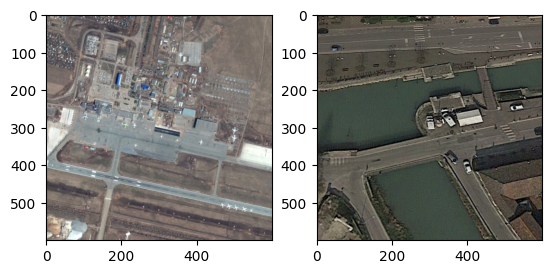

In [3]:
image1,image2 = skimage.io.imread("/content/data/train/airport_153.jpg"), skimage.io.imread("/content/data/train/bridge_221.jpg")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(image1)
ax2.imshow(image2)


## 进行实验

### **构建数据(TODO)**

In [4]:
# training 时做 data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 图像上下翻转
    transforms.RandomRotation(15), # 图像旋转
    transforms.ToTensor(), # 将图像转成 Tensor，并把数值 normalize 到 [0,1] (data normalization)
])
# testing 时不需要做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
class RsDataset(data.Dataset):
    def __init__(self, mode):
        self.mode = mode
        self.data_tokens = glob(os.path.join(f"/content/data/{mode}/*.jpg"))
    def __getitem__(self, index):
        image_path = self.data_tokens[index]
        image = skimage.io.imread(image_path)
        image_name = os.path.basename(image_path)
        if self.mode == "test":
          image = test_transform(image)
          return image,image_name

        elif self.mode == "val":
          image = test_transform(image)
          label_tag = image_name.split("_")[0]
          label = labels[label_tag]
          label = torch.tensor(label)
          return image,label
        else:
          image = train_transform(image)
          label_tag = image_name.split("_")[0]
          label = labels[label_tag]
          label = torch.tensor(label)
          return image,label
    def __len__(self):
        return len(self.data_tokens)


### **搭建模型(TODO)**


In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 维度 [3, 600, 600]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 600, 600]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 300, 300]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 300, 300]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 150, 150]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 150, 150]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 75, 75]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 75, 75]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 37, 37]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 37, 37]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 18, 18]
        )
        self.avg_pool = nn.AdaptiveAvgPool2d((4,4)) # [512, 4, 4]
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = self.avg_pool(out)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

### **训练与验证**




#### 超参数配置(TODO)

In [6]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss()
learning_rate = 0.001
num_epoch = 30
batch_size = 16
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # optimizer 使用 SGD

#### 构建数据集

In [7]:
train_set = RsDataset("train")
val_set = RsDataset("val")
test_set = RsDataset("test")
train_loader = data.DataLoader(train_set,batch_size = batch_size, num_workers = 1)
val_loader = data.DataLoader(val_set, batch_size = batch_size, num_workers = 1)
test_loader = data.DataLoader(test_set, batch_size = 1, shuffle=False, num_workers = 1)

#### 训练与验证(TODO)

In [8]:
os.makedirs('models', exist_ok=True)
os.makedirs('pre',exist_ok=True)
loss_log = {"train_loss": [], "val_loss": []}
acc_log = {"train_acc": [], "val_acc": []}
best_acc = 0.0
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    best_acc = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        train_pred = model(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward() # 梯度回传
        optimizer.step()
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy()) # 输出结果是对每一个类别的预测概率，因此需要获取概率最大的类别，然后再与标签计算acc
        train_loss += batch_loss.item()

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
            train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
    if (val_acc/val_set.__len__())>best_acc:
        best_acc = (val_acc/val_set.__len__())
        best_state_dict = model.state_dict()
    loss_log["train_loss"].append(train_loss/train_set.__len__())
    loss_log["val_loss"].append(val_loss/val_set.__len__())
    acc_log["train_acc"].append(train_acc/train_set.__len__())
    acc_log["val_acc"].append(val_acc/val_set.__len__())
    if best_state_dict is not None:
        torch.save(best_state_dict, "models/model" + ".ckpt")
        print(f"epoch {epoch + 1}, best model saved. (accuracy={(val_acc/val_set.__len__()):.4f})")
        best_state_dict = None

[001/030] 101.96 sec(s) Train Acc: 0.248602 Loss: 0.137391 | Val Acc: 0.296610 loss: 0.138747
epoch 1, best model saved. (accuracy=0.2966)
[002/030] 95.40 sec(s) Train Acc: 0.368602 Loss: 0.125354 | Val Acc: 0.364407 loss: 0.128597
epoch 2, best model saved. (accuracy=0.3644)
[003/030] 96.89 sec(s) Train Acc: 0.433978 Loss: 0.113570 | Val Acc: 0.403955 loss: 0.118015
epoch 3, best model saved. (accuracy=0.4040)
[004/030] 97.09 sec(s) Train Acc: 0.486022 Loss: 0.103453 | Val Acc: 0.429379 loss: 0.108656
epoch 4, best model saved. (accuracy=0.4294)
[005/030] 96.12 sec(s) Train Acc: 0.531613 Loss: 0.095079 | Val Acc: 0.471751 loss: 0.100566
epoch 5, best model saved. (accuracy=0.4718)
[006/030] 96.48 sec(s) Train Acc: 0.559140 Loss: 0.088013 | Val Acc: 0.483051 loss: 0.093980
epoch 6, best model saved. (accuracy=0.4831)
[007/030] 97.54 sec(s) Train Acc: 0.583656 Loss: 0.081765 | Val Acc: 0.511299 loss: 0.088725
epoch 7, best model saved. (accuracy=0.5113)
[008/030] 96.83 sec(s) Train Acc:

#### 查看损失和精度曲线

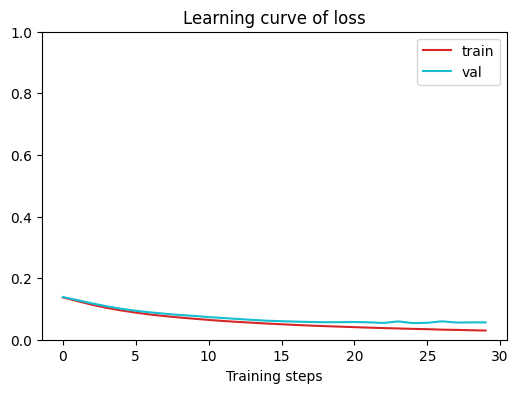

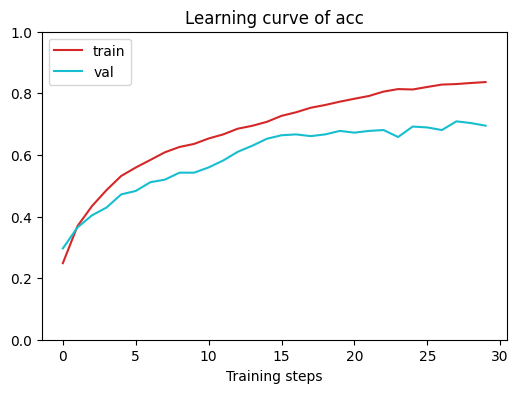

In [9]:
import matplotlib.pyplot as plt # 用来绘制曲线
from matplotlib.pyplot import figure

def plot_learning_curve(loss_record, title='',y_max=1):
  total_steps = len(loss_record[f'train_{title}'])
  x_1 = range(total_steps)
  x_2 = x_1[::len(loss_record[f'train_{title}']) // len(loss_record[f'val_{title}'])]
  figure(figsize=(6, 4))
  plt.plot(x_1, loss_record[f'train_{title}'], c='tab:red', label='train')
  plt.plot(x_2, loss_record[f'val_{title}'], c='tab:cyan', label='val')
  plt.ylim(0.0, y_max)
  plt.xlabel('Training steps')
  plt.title('Learning curve of {}'.format(title))
  plt.legend()
  plt.show()

plot_learning_curve(loss_log,"loss",1) # loss的变化曲线
plot_learning_curve(acc_log,"acc",1) # acc的变化曲线

#### 利用训练好的模型在测试集上生成测试结果
运行完这段代码后，你会在左侧文件目录下方找到"pred.csv"文件，下载该文件并提交到kaggle上，系统会返回给你测试精度

In [10]:
checkPoint=torch.load("/content/models/model.ckpt")
model.load_state_dict(checkPoint)
model.eval()
header = ["ID", "label"]
with open("pred.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i, (x,image_name) in enumerate(test_loader):
        with torch.no_grad():
            test_pred = model(x.cuda())
            test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
            in_data = [image_name[0], test_label[0]]
            writer.writerow(in_data)
    print("成功得到了测试集的预测结果!")

成功得到了测试集的预测结果!


## 你需要做什么

**基本要求**


*   弄明白这些代码都在干什么



**中等要求**

*   参数调整：在主程序中，有很多超参数，如learning rate，batch size等，调整他们会改进模型的精度吗。关于优化器(optimizer)，我们使用的是SGD，有没有其它的优化器可以使用呢，这些优化器里的超参数（如momentum）需要怎么设置呢？


*   数据增强：数据增强也叫数据扩增，意思是在不实质性的增加数据的情况下，让有限的数据产生等价于更多数据的价值。对于图像来说，常见的数据增强包括旋转、平移、缩放等。你可以实现这些数据增强吗？实现这些数据增强会提升模型的泛化性能吗？

*   训练方式：用于训练的数据量的大小对模型的精度有较大影响, 在进行最终测试集验证前，可以尝试把验证集并入训练集再进行几个epoch的训练来提升模型泛化性能。

**终极要求**

*   自己对模型的结构进行修改，或直接引入更先进的模型，从而提高最终精度

*   其它：发挥你的想法，尽可能地减小测试集误差，并解释为什么